In [1]:
@everywhere include("../Source/ChiralMC.jl")
@everywhere using ChiralMC

In [2]:
@everywhere include("../Source/functions_msc.jl")
@everywhere include("../Source/functions_observables.jl")
@everywhere include("../Source/functions_parallel.jl")
include("../Source/functions_plots_and_files.jl")

initializeTwoStatesS (generic function with 1 method)

In [40]:
@everywhere const two_pi = 2π

# We run a simulation with the parameters
g = 0.3    # Gauge coupling
ν = 0.3    # Anisotropy
H = -0.72   # External field

# Other parameters
L = 32     # System length
T = 0.4   # Temperature
γ = 1.0    # Order parameter amplitud

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = ceil(abs(H/(2π)*L))/L*sign(H)
# Calculate inverse temperature
β = 1/T

# Create system
syst = SystConstants(L, γ, 1/g^2, ν, f, β)
sim = Controls(π/3, 0.4, 3.0)

# Measurement parameters
M = 300    # Number of measurements
Δt = 200  # Interval between measurements (MCS)
# Construct k-matrix where the horizontal axis contains kx ∈ [-π, π), while
# the vertical axis contain ky ∈ [-π, π) at the second component
k_matrix = [[2π/L*(x-1-L/2), 2π/L*(L/2-y)] for y=1:L, x=1:L];

Finding Equilibrium of
ChiralMC.SystConstants(32, 1.0, 11.11111111111111, 0.3, -0.125, 2.5)
ChiralMC.Controls(1.0471975511965976, 0.4, 3.0)
Searching for ΔE <= 0..
ΔE <= 0 found at t₀ = 2000!
Checking if average is close to 0..
0% of max
Equilibrium found at time 12170
over the interval [2000, 2250]
s.t. <ΔE> = 5.36 ± 1.4
std(ΔE) = 21.5


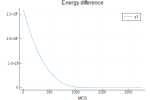

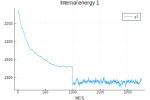

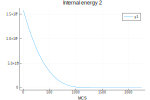

Performing extra MCS
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
Calculating energies and acceptance rates


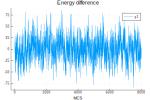

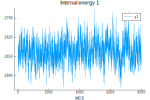

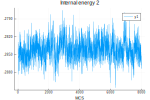

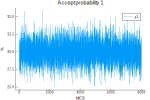

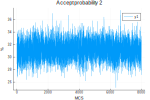

In [41]:
(ψ₁, sim₁, ψ₂, sim₂, t₀) = initializeTwoStates(syst, sim);

In [48]:
ψ = copy(ψ₁);

## First we make a function for sending argument to $[-\pi, \pi)$

In [27]:
using BenchmarkTools
using Distributions

In [21]:
function drawback{T<:Real}(x::T)
    return x - two_pi*fld(x+π, two_pi)
end
function drawback2{T<:Real}(x::T)
    return mod2pi(x+π)-π
end

drawback2 (generic function with 1 method)

In [38]:
x = rand(Uniform(-π,π))
@benchmark drawback($x)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     11.040 ns (0.00% GC)
  median time:      11.059 ns (0.00% GC)
  mean time:        11.218 ns (0.00% GC)
  maximum time:     22.129 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     999

In [39]:
@benchmark drawback2($x)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     8.759 ns (0.00% GC)
  median time:      8.773 ns (0.00% GC)
  mean time:        8.895 ns (0.00% GC)
  maximum time:     19.892 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     999

**Conclusion:** drawback2 seems to be marginally faster.

# Different vorticity functions

 We will use the parallelized `parallelSFVLA!` function to measure the structure function and vortex lattice. This function calls `sfvlaMeasure!` for each process that should measure something. This function then uses `vortexSnapshot`to measure the vorticity of all points in the lattice and this result is then fed into `structureFunction` which is responsible for calculating the Fourier Transform. It is thus the `vortexSnapshot` function which determines how vorticity is measured. `vortexSnapshot` is loaded from __functions_observables.jl__ and uses the `nᵣ(syst, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)` function to measure the vorticity. Overwriting `nᵣ` thus seems to be the easiest way of testing different methods of calculating vorticity.

The version of `nᵣ` loaded from __function_observables.jl__ is given by

In [42]:
function nᵣ(c::SystConstants, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, ϕᵣ₊₁₊₂::LatticeSite, h_pos::Int64)
    vort_θ⁺ = (mod(ϕᵣ₊₁.θ⁺ - ϕ.θ⁺, two_pi) - ϕ.A[1] + mod(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₁.θ⁺, two_pi) - (ϕᵣ₊₁.A[2] + two_pi*c.f*h_pos)
        - mod(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₂.θ⁺, two_pi)  + ϕᵣ₊₂.A[1]
        - mod(ϕᵣ₊₂.θ⁺ - ϕ.θ⁺, two_pi)  + (ϕ.A[2] + two_pi*c.f*(h_pos-1)))
    vort_θ⁻ = (mod(ϕᵣ₊₁.θ⁻ - ϕ.θ⁻, two_pi) - ϕ.A[1] + mod(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₁.θ⁻, two_pi) - (ϕᵣ₊₁.A[2] + two_pi*c.f*h_pos)
        - mod(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₂.θ⁻, two_pi)  + ϕᵣ₊₂.A[1]
        - mod(ϕᵣ₊₂.θ⁻ - ϕ.θ⁻, two_pi)  + (ϕ.A[2] + two_pi*c.f*(h_pos-1)))
    return vort_θ⁺, vort_θ⁻
end

nᵣ (generic function with 1 method)

### Gauge invariant phase
We now change it so that the vorticity is calculated as a gauge-invariant phase and drawn back in the $[-\pi, \pi)$ interval.

In [234]:
function nᵣ(c::SystConstants, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, ϕᵣ₊₁₊₂::LatticeSite, h_pos::Int64)
    vort_θ⁺ = (drawback(ϕᵣ₊₁.θ⁺ - ϕ.θ⁺ - ϕ.A[1]) + drawback(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₁.θ⁺ - (ϕᵣ₊₁.A[2] + two_pi*c.f*h_pos))
        - drawback(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₂.θ⁺  - ϕᵣ₊₂.A[1])
        - drawback(ϕᵣ₊₂.θ⁺ - ϕ.θ⁺  - (ϕ.A[2] + two_pi*c.f*(h_pos-1))))
    vort_θ⁻ = (drawback(ϕᵣ₊₁.θ⁻ - ϕ.θ⁻ - ϕ.A[1]) + drawback(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₁.θ⁻ - (ϕᵣ₊₁.A[2] + two_pi*c.f*h_pos))
        - drawback(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₂.θ⁻  - ϕᵣ₊₂.A[1])
        - drawback(ϕᵣ₊₂.θ⁻ - ϕ.θ⁻  - (ϕ.A[2] + two_pi*c.f*(h_pos-1))))
    return vort_θ⁺, vort_θ⁻
end

nᵣ (generic function with 1 method)

### Testing new vorticity
We want the result of the voritcity to be $2\pi n$ for $n\in\mathbb{N}$

In [280]:
# We assume that we are not in the corners
(V⁺, V⁻) = vortexSnapshot(ψ);

In [300]:
v_pos = rand(1:L)
h_pos = rand(1:L)
(V⁺[v_pos,h_pos])/two_pi

-0.96326124003492

**Conclusion:** When we add $2\pi f$ this does actually seem to give a result that is $\approx 2\pi n$!!!

In [260]:
# Based on the above we thus modify nᵣ further to add the 2πf to the vorticity
function nᵣ(c::SystConstants, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, ϕᵣ₊₁₊₂::LatticeSite, h_pos::Int64)
    vort_θ⁺ = (drawback(ϕᵣ₊₁.θ⁺ - ϕ.θ⁺ - ϕ.A[1]) + drawback(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₁.θ⁺ - (ϕᵣ₊₁.A[2] + two_pi*c.f*h_pos))
        - drawback(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₂.θ⁺  - ϕᵣ₊₂.A[1])
        - drawback(ϕᵣ₊₂.θ⁺ - ϕ.θ⁺  - (ϕ.A[2] + two_pi*c.f*(h_pos-1)))+two_pi*c.f)
    vort_θ⁻ = (drawback(ϕᵣ₊₁.θ⁻ - ϕ.θ⁻ - ϕ.A[1]) + drawback(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₁.θ⁻ - (ϕᵣ₊₁.A[2] + two_pi*c.f*h_pos))
        - drawback(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₂.θ⁻  - ϕᵣ₊₂.A[1])
        - drawback(ϕᵣ₊₂.θ⁻ - ϕ.θ⁻  - (ϕ.A[2] + two_pi*c.f*(h_pos-1)))+two_pi*c.f)
    return vort_θ⁺, vort_θ⁻
end

nᵣ (generic function with 1 method)

In [261]:
# We assume that we are not in the corners
(V⁺, V⁻) = vortexSnapshot(ψ);

In [275]:
v_pos = rand(1:L)
h_pos = rand(1:L)
(V⁺[v_pos,h_pos])/two_pi

1.0109238802020502

### Performing  thermal average

In [276]:
ψ_list = parallelMultiplyState(ψ₁, sim₁, t₀);

In [277]:
(av_V⁺, err_V⁺, V⁺, av_V⁻, err_V⁻, V⁻, av_S⁺, err_S⁺, S⁺, av_S⁻, err_S⁻, S⁻) = parallelSFVLA!(k_matrix, ψ_list, sim₁, M, Δt);

Starting 300 measurements on 3 processes doing max 100 measurements each
on a 32×32 system.
Measurement progress: 10%
Measurement progress: 20%
Measurement progress: 30%
Measurement progress: 40%
Measurement progress: 50%
Measurement progress: 60%
Measurement progress: 70%
Measurement progress: 80%
Measurement progress: 90%
Measurement progress: 100%
Measurements done, collecting parallell results.
Parallell measurements done. Processing.

Sum of vorticity of random snapshot:
V⁺: 	128.00000000000003
V⁻: 	128.00000000000003

Max (S⁺, S⁻)
(0.9999999999999998, 1.0)
Max δ(S⁺, S⁻)
(0.00017037992201434502, 0.000431153184852589)
Max correlation time
(41.77216673744584, 53.46764866306161)


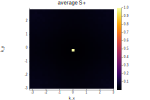

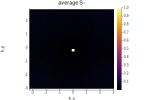

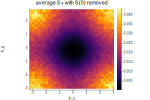

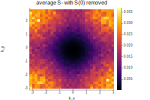

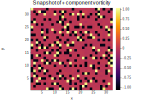

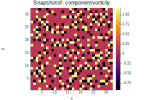

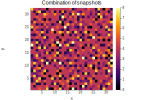

S⁺(0) ≈ 0.9999999999999998
S⁻(0) ≈ 1.0
The proportion of vortices (n⁺, n⁻) in snapshot
% of vortex kind (-1, -1): 	4
% of vortex kind (-1, 0): 	13
% of vortex kind (-1, 1): 	4
% of vortex kind (0, -1): 	12
% of vortex kind (0, 0): 	47
% of vortex kind (0, 1): 	11
% of vortex kind (1, -1): 	1
% of vortex kind (1, 0): 	5
% of vortex kind (1, 1): 	2

Sum of + component vorticity in the snapshot: -128.00000000000014
Sum of - component vorticity in the snapshot: 128.00000000000006


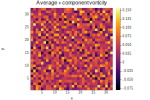

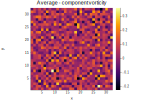

In [278]:
plotStructureFunctionVortexLattice(av_V⁺, av_V⁻, V⁺[rand(1:M)], V⁻[rand(1:M)], av_S⁺, av_S⁻, k_matrix)

**Conclusion:** This seems very good since we get the correct normalization while still calculating a gauge-invariant phase.